In [9]:
import os
import json
import torch
import numpy as np
import cv2
import tqdm
"""
os.chdir('../')
os.getcwd()"""

"\nos.chdir('../')\nos.getcwd()"

In [3]:
from augmentation import RoMixGen_Img, RoMixGen_Txt
import random
from PIL import Image 
from torchvision import transforms 

In [4]:
transform_after_mix = transforms.Compose([
                                            transforms.RandomResizedCrop(256,scale=(0.5, 1.0), interpolation=Image.BICUBIC),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
                                        ])

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:891: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [5]:
RoMixGen_Img = RoMixGen_Img(image_dict = json.load(open('data/COCO/Annotations/coco_img_info_0.01_bbox_center_0.7.json')),
                            image_root = 'data/COCO/Images_0.01_bbox_center_0.7',
                            transform_after_mix = transform_after_mix,
                            resize_ratio = 2)
RoMixGen_Txt = RoMixGen_Txt(image_caption = json.load(open('data/COCO/Annotations/coco_img_info_0.01_bbox_center_0.7.json')))

In [6]:
with open ('data/COCO/Annotations/coco_objbg_info_0.01_bbox_center_0.7.json') as f:
    objbg_dict = json.load(f)
with open ('data/COCO/Annotations/coco_img_info_0.01_bbox_center_0.7.json') as f:
    image_dict = json.load(f)
with open ('data/COCO/Annotations/coco.json') as f:
    original_dataset = json.load(f)

In [7]:
# make 123,287 romixed images and captions
# new image id start from 000001 ~ 123287
# save image to data/COCO/pre_romix_coco_0.01_bbox_center_0.7
# save caption to data/COCO/Anotations/pre_romix_caption_0.01_bbox_center_0.7.json
total_imagenum = 123287
obj_ids = objbg_dict['obj']
bg_ids = objbg_dict['bg']

In [8]:
import os

classic_dataset = []
new_dataset = {}

if not os.path.exists('data/COCO/pre_romix_coco_0.01_bbox_center_0.7'):
    os.makedirs('data/COCO/pre_romix_coco_0.01_bbox_center_0.7')

for img_id in tqdm(range(total_imagenum)):
    # Keep retrying until the image generation succeeds
    while True:
        obj_id, bg_id = str(random.choice(obj_ids)), str(random.choice(bg_ids))
        try:
            img = RoMixGen_Img(obj_id, bg_id)
            break # exit the loop if image generation succeeds
        except:
            continue

    txt = RoMixGen_Txt(obj_id, bg_id)
    img = torch.permute(img, (1,2,0)).detach().numpy()
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img = img*255

    # Write image to disk
    img_path = os.path.join('data/COCO/pre_romix_coco_0.01_bbox_center_0.7', f'{img_id:06d}.jpg')
    cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    # Add captions to datasets
    for _ in txt:
        classic_dataset.append({'caption': _, 'image': img_path, 'image_id': f"coco_{img_id:06d}"})
    if str(img_id) not in new_dataset:
        new_dataset[str(img_id)] = []
    new_dataset[str(img_id)].extend(txt)

    # dump datasets
    if img_id % 100 == 0:
        with open('data/COCO/Annotations/pre_romix_caption_0.01_bbox_center_0.7.json', 'w') as f:
            json.dump(classic_dataset, f)
        with open('data/COCO/Annotations/pre_romix_caption_new_0.01_bbox_center_0.7.json', 'w') as f:
            json.dump(new_dataset, f)


/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Error generating image with obj_id 8749 and bg_id 334232. Retrying with new IDs...
Error generating image with obj_id 216449 and bg_id 566025. Retrying with new IDs...
Error generating image with obj_id 160559 and bg_id 276267. Retrying with new IDs...
Error generating image with obj_id 414736 and bg_id 535322. Retrying with new IDs...
Error generating image with obj_id 162503 and bg_id 357948. Retrying with new IDs...
Error generating image with obj_id 527243 and bg_id 466511. Retrying with new IDs...
Error generating image with obj_id 542928 and bg_id 516974. Retrying with new IDs...
Error generating image with obj_id 393033 and bg_id 443941. Retrying with new IDs...
Error generating image with obj_id 45885 and bg_id 98048. Retrying with new IDs...
Error generating image with obj_id 394974 and bg_id 464296. Retrying with new IDs...
Error generating image with obj_id 444339 and bg_id 508771. Retrying with new IDs...
Error generating image with obj_id 430686 and bg_id 530013. Retrying 

KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt

In [19]:
img = RoMixGen_Img(obj_id, bg_id)
img = torch.permute(img, (1,2,0)).detach().numpy()
img = (img - np.min(img)) / (np.max(img) - np.min(img))
img= img*255
cv2.imwrite('data/COCO/temp.jpg',cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

True

In [32]:
#img = (img - np.min(img)) / (np.max(img) - np.min(img))

In [33]:
# save as using cv2.imread
cv2.imwrite('data/COCO/temp.jpg', img)a

True

In [27]:
Image.fromarray(img.numpy().transpose(1,2,0).squeeze())

TypeError: Cannot handle this data type: (1, 1, 3), <f4

In [10]:
obj_id, bg_id

('450974', '286521')

In [33]:
RoMixGen_Img.image_dict[bg_id]["file_name"]

'COCO_train2014_000000286521.jpg'

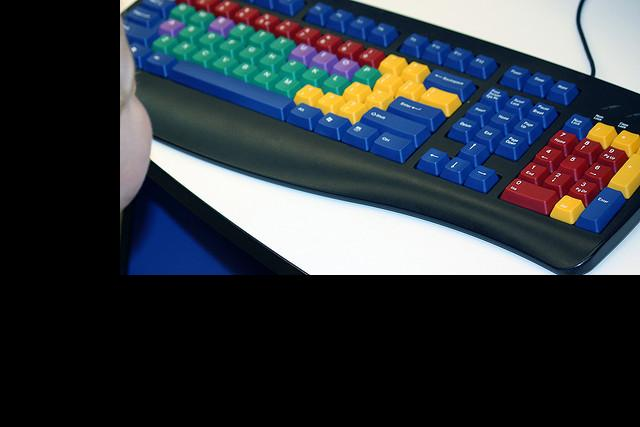

In [38]:
Image.open(os.path.join(RoMixGen_Img.image_root,'obj', RoMixGen_Img.image_dict[obj_id]["file_name"]))

In [34]:
RoMixGen_Img(obj_id,bg_id)

UnboundLocalError: local variable 'img' referenced before assignment

In [12]:
image_dict = json.load(open('data/COCO/Annotations/coco_img_info_0.01_bbox_center_0.7.json'))

In [13]:
def replace_word(captions, bg_cats, obj_cats):
    replaced = False
    for bg_cat, obj_cat in zip(bg_cats, obj_cats):
        if bg_cat in captions:
            captions = captions.replace(bg_cat, obj_cat)
            replaced = True
    if not replaced:
        captions = random.choice(obj_cats) + " " + captions
    return captions

In [14]:
captions = image_dict['112493']["captions"]
bg_cat = image_dict['112493']["max_obj_cat"] + image_dict['112493']["max_obj_super_cat"]
obj_cat = image_dict[str(random.choice(obj_ids))]["max_obj_cat"] + image_dict[str(random.choice(obj_ids))]["max_obj_super_cat"]

In [15]:
captions, bg_cat, obj_cat

(['a tennis player standing on a tennis court',
  'a person hitting a tennis ball while playing a game ',
  'The tennis player in a green shirt hits a ball on the clay court.',
  'A man on a tennis court swinging a racket. ',
  'A man standing on a tennis court while holding a racquet.'],
 ['person', 'people', 'person', 'people'],
 ['person', 'people', 'animal', 'animals'])

In [16]:
concat_cap = [replace_word(caption,bg_cat,obj_cat) for caption in captions]

In [17]:
concat_cap

['people a tennis player standing on a tennis court',
 'a animal hitting a tennis ball while playing a game ',
 'people The tennis player in a green shirt hits a ball on the clay court.',
 'animal A man on a tennis court swinging a racket. ',
 'people A man standing on a tennis court while holding a racquet.']

In [24]:
obj_id, bg_id

('450974', '286521')

In [22]:
RoMixGen_Txt(obj_id,bg_id)

TypeError: replace_word() takes 3 positional arguments but 4 were given